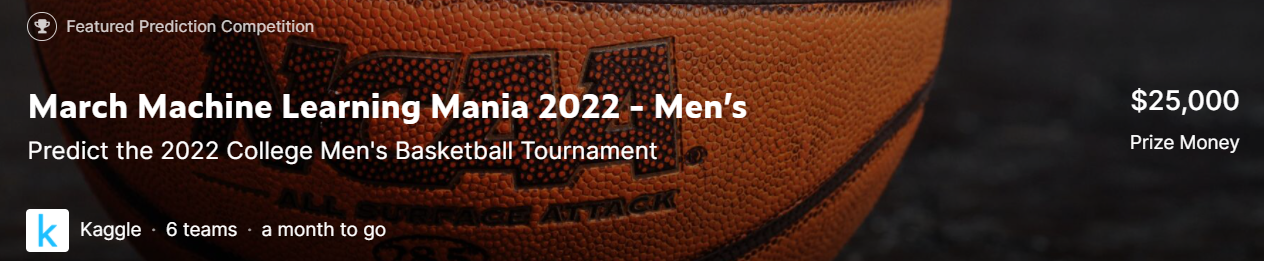

## This is a future prediction type competition.
## It seems to be held every year, and one of the features of this competition is that there are many CSV files.
## I think this one is more challenging than the women's version, which is being held at the same time, because there are more files.
## First, let's read the data.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Import</span>

In [ ]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc
import seaborn as sns
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json
import plotly.express as ex

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 1 - The Basics</span>

In [ ]:
MTeams = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MTeams.csv')
MTeams

In [ ]:
np.min(MTeams.FirstD1Season)

TeamID - a 4 digit id number, from 1000-1999, uniquely identifying each NCAA® men's team. A school's TeamID does not change from one year to the next, so for instance the Duke men's TeamID is 1181 for all seasons. To avoid possible confusion between the men's data and the women's data, all of the men's team ID's range from 1000-1999, whereas all of the women's team ID's range from 3000-3999.<br>
TeamName - a compact spelling of the team's college name, 16 characters or fewer. There are no commas or double-quotes in the team names, but you will see some characters that are not letters or spaces, e.g., Texas A&M, St Mary's CA, TAM C. Christi, and Bethune-Cookman.<br>
FirstD1Season - the first season in our dataset that the school was a Division-I school. For instance, FL Gulf Coast (famously) was not a Division-I school until the 2008 season, despite their two wins just five years later in the 2013 NCAA® tourney. Of course, many schools were Division-I far earlier than 1985, but since we don't have any data included prior to 1985, all such teams are listed with a FirstD1Season of 1985.
LastD1Season - the last season in our dataset that the school was a Division-I school. For any teams that are currently Division-I, they will be listed with LastD1Season=2022, and you can confirm there are 358 such teams.

In [ ]:
MSeasons =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MSeasons.csv')
MSeasons

Season - indicates the year in which the tournament was played. Remember that the current season counts as 2022.<br>
DayZero - tells you the date corresponding to DayNum=0 during that season. All game dates have been aligned upon a common scale so that (each year) the Monday championship game of the men's tournament is on DayNum=154. Working backward, the national semifinals are always on DayNum=152, the "play-in" games are on days 135, Selection Sunday is on day 132, the final day of the regular season is also day 132, and so on. All game data includes the day number in order to make it easier to perform date calculations. If you need to know the exact date a game was played on, you can combine the game's "DayNum" with the season's "DayZero". For instance, since day zero during the 2011-2012 season was 10/31/2011, if we know that the earliest regular season games that year were played on DayNum=7, they were therefore played on 11/07/2011.<br>
RegionW, RegionX, Region Y, Region Z - by our contests' convention, each of the four regions in the final tournament is assigned a letter of W, X, Y, or Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files, even if the region names change from year to year. For instance, during the 2012 tournament, the four regions were East, Midwest, South, and West. Being the first alphabetically, East becomes W. Since the East regional champion (Ohio State) played against the Midwest regional champion (Kansas) in the national semifinals, that makes Midwest be region X. For the other two (South and West), since South comes first alphabetically, that makes South Y and therefore West is Z. So for that season, the W/X/Y/Z are East,Midwest,South,West. And so for instance, Ohio State, the #2 seed in the East, is listed in the MNCAATourneySeeds file that year with a seed of W02, meaning they were the #2 seed in the W region (the East region). We will not know the final W/X/Y/Z designations until Selection Sunday, because the national semifinal pairings in the Final Four will depend upon the overall ranks of the four #1 seeds.


In [ ]:
MRegularSeasonCompactResults = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
MRegularSeasonCompactResults

In [ ]:
MRegularSeasonCompactResults['score'] =MRegularSeasonCompactResults.WScore - MRegularSeasonCompactResults.LScore

In [ ]:
data = MRegularSeasonCompactResults.groupby('WTeamID').agg(score=('score','mean'))
sns.relplot(x=data.index, y='score', data=data, kind='line',ci='sd')
plt.gcf().set_size_inches(20, 10)
plt.show()

Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs). For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.<br>
DayNum - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "MSeasons.csv" file. For example, the first game in the file was DayNum=20. Combined with the fact from the "MSeasons.csv" file that day zero was 10/29/1984 that year, this means the first game was played 20 days later, or 11/18/1984. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID). In order to accomplish this uniqueness, we had to adjust one game's date. In March 2008, the SEC postseason tournament had to reschedule one game (Georgia-Kentucky) to a subsequent day because of a tornado, so Georgia had to actually play two games on the same day. In order to enforce this uniqueness, we moved the game date for the Georgia-Kentucky game back to its original scheduled date.
WTeamID - this identifies the id number of the team that won the game, as listed in the "MTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.<br>
WScore - this identifies the number of points scored by the winning team.<br>
LTeamID - this identifies the id number of the team that lost the game.<br>
LScore - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.<br>
WLoc - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.<br>
NumOT - this indicates the number of overtime periods in the game, an integer 0 or higher.


In [ ]:
MNCAATourneyCompactResults = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
MNCAATourneyCompactResults

DayNum=134 or 135 (Tue/Wed) - play-in games to get the tournament field down to the final 64 teams<br>
DayNum=136 or 137 (Thu/Fri) - Round 1, to bring the tournament field from 64 teams to 32 teams<br>
DayNum=138 or 139 (Sat/Sun) - Round 2, to bring the tournament field from 32 teams to 16 teams<br>
DayNum=143 or 144 (Thu/Fri) - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams<br>
DayNum=145 or 146 (Sat/Sun) - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams<br>
DayNum=152 (Sat) - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams<br>
DayNum=154 (Mon) - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

In [ ]:
MSampleSubmissionStage1 =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MSampleSubmissionStage1.csv')
MSampleSubmissionStage1

ID - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.<br>
Pred - this contains the predicted winning percentage for the first team identified in the ID field, the one represented above by XXXX.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 2 - Team Box Scores</span>

In [ ]:
MRegularSeasonDetailedResults =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
MRegularSeasonDetailedResults

WFGM - field goals made (by the winning team)<br>
WFGA - field goals attempted (by the winning team)<br>
WFGM3 - three pointers made (by the winning team)<br>
WFGA3 - three pointers attempted (by the winning team)<br>
WFTM - free throws made (by the winning team)<br>
WFTA - free throws attempted (by the winning team)<br>
WDR - defensive rebounds (pulled by the winning team)<br>
WAst - assists (by the winning team)<br>
WTO - turnovers committed (by the winning team)<br>
WStl - steals (accomplished by the winning team)<br>
WBlk - blocks (accomplished by the winning team)<br>
WPF - personal fouls committed (by the winning team)<br>

In [ ]:
point =['WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

In [ ]:
data = MRegularSeasonDetailedResults.groupby('WTeamID').mean()
fig = plt.figure(figsize=(30,80))
x=1
for i in point: 
    fig.add_subplot(15,5, x)
    plt.title(i,fontsize=18)
    plt.plot(data.index,data[i])
    x+=1

In [ ]:
MRegularSeasonDetailedResults['score'] =MRegularSeasonDetailedResults.WScore - MRegularSeasonDetailedResults.LScore
qx = sns.jointplot(x=MRegularSeasonDetailedResults.WTeamID.unique(), y=MRegularSeasonDetailedResults.groupby(['WTeamID'])['score'].mean().values, kind="reg", 
                   height=8, joint_kws={'line_kws':{'color':'red'}})
qx.ax_joint.set_xlabel('WteamID')
qx.ax_joint.set_ylabel('score')
plt.show()

In [ ]:
team = MRegularSeasonDetailedResults.groupby(['WTeamID']).mean().reset_index()
team

In [ ]:
win = MRegularSeasonDetailedResults.WTeamID.value_counts()
teams = pd.DataFrame()
for i in win.index:
    data = team[team.WTeamID ==i]
    data['win'] = win[i]
    teams = pd.concat([teams,data])
teams

In [ ]:
sns.relplot(x='score',y='win',data=teams)
plt.gcf().set_size_inches(8, 8)

In [ ]:
fig = plt.figure(figsize=(30,80))
r=1 
for x in point:    
        fig.add_subplot(10,5, r)
        plt.title(x,fontsize=18)
        plt.scatter(x='win',y=x,data=teams)
        #p.set_title(x)
        r+=1 

In [ ]:
MNCAATourneyDetailedResults =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
MNCAATourneyDetailedResults

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 3 - Geography</span>

In [ ]:
Cities =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/Cities.csv')
Cities

CityID - a four-digit ID number uniquely identifying a city.<br>
City - the text name of the city.<br>
State - the state abbreviation of the state that the city is in. In a few rare cases, the game location is not inside one of the 50 U.S. states and so other abbreviations are used. For instance Cancun, Mexico has a state abbreviation of MX.

In [ ]:
MGameCities = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MGameCities.csv')
MGameCities

Season, DayNum, WTeamID, LTeamID - these four columns are sufficient to uniquely identify each game. Additional data, such as the score of the game and other stats, can be found in the corresponding Compact Results and/or Detailed Results file.<br>
CRType - this can be either Regular or NCAA or Secondary. If it is Regular, you can find more about the game in the MRegularSeasonCompactResults.csv and MRegularSeasonDetailedResults.csv files. If it is NCAA, you can find more about the game in the MNCAATourneyCompactResults.csv and MNCAATourneyDetailedResults.csv files. If it is Secondary, you can find more about the game in the MSecondaryTourneyCompactResults file.<br>
CityID - the ID of the city where the game was played, as specified by the CityID column in the Cities.csv file.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 4 - Public Rankings</span>

In [ ]:
MMasseyOrdinals =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MMasseyOrdinals.csv')
MMasseyOrdinals

Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)<br>
RankingDayNum - this integer always ranges from 0 to 133, and is expressed in the same terms as a game's DayNum (where DayZero is found in the MSeasons.csv file). The RankingDayNum is intended to tell you the first day that it is appropriate to use the rankings for predicting games. For example, if RankingDayNum is 110, then the rankings ought to be based upon game outcomes up through DayNum=109, and so you can use the rankings to make predictions of games on DayNum=110 or later. The final pre-tournament rankings each year have a RankingDayNum of 133, and can thus be used to make predictions of the games from the NCAA® tournament, which start on DayNum=134 (the Tuesday after Selection Sunday).<br>
SystemName - this is the (usually) 3-letter abbreviation for each distinct ranking system. These systems may evolve from year to year, but as a general rule they retain their meaning across the years. Near the top of the Massey composite page, you can find slightly longer labels describing each system, along with links to the underlying pages where the latest rankings are provided (and sometimes the calculation is described).
TeamID - this is the ID of the team being ranked, as described in MTeams.csv.<br>
OrdinalRank - this is the overall ranking of the team in the underlying system. Most systems from recent seasons provide a complete ranking from #1 through #351, but more recently they go higher because additional teams were added to Division I in recent years.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Data Section 5 - Supplements</span>

In [ ]:
MTeamCoaches =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MTeamCoaches.csv')
MTeamCoaches

Season - this is the year of the associated entry in MSeasons.csv (the calendar year in which the final tournament occurs)<br>
TeamID - this is the TeamID of the team that was coached, as described in MTeams.csv.<br>
FirstDayNum, LastDayNum - this defines a continuous range of days within the season, during which the indicated coach was the head coach of the team. In most cases, a data row will either have FirstDayNum=0 (meaning they started the year as head coach) and/or LastDayNum=154 (meaning they ended the year as head coach), but in some cases there were multiple new coaches during a team's season, or a head coach who went on leave and then returned (in which case there would be multiple records in that season for that coach, indicating the continuous ranges of days when they were the head coach).<br>
CoachName - this is a text representation of the coach's full name, in the format first_last, with underscores substituted in for spaces.


In [ ]:
Conferences = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/Conferences.csv')
Conferences

ConfAbbrev - this is a short abbreviation for each conference; the abbreviation is used in some other files to indicate the parent conference of a team or of a conference tournament.<br>
Description - this is a longer text name for the conference.

In [ ]:
MTeamConferences =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MTeamConferences.csv')
MTeamConferences

Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)<br>
TeamID - this identifies the TeamID (as described in MTeams.csv).<br>
ConfAbbrev - this identifies the conference (as described in Conferences.csv).

In [ ]:
MConferenceTourneyGames =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MConferenceTourneyGames.csv')
MConferenceTourneyGames

ConfAbbrev - this identifies the conference (as described in Conferences.csv) that the tournament was for.<br>
Season, DayNum, WTeamID, LTeamID - these four columns are sufficient to uniquely identify each game. Further details about the game, such as the final score and other stats, can be found in the associated data row of the MRegularSeasonCompactResults and/or MRegularSeasonDetailedResults files.

In [ ]:
MSecondaryTourneyTeams =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MSecondaryTourneyTeams.csv')
MSecondaryTourneyTeams

Season - this is the year of the associated entry in MSeasons.csv (the year in which the post-season tournament was played)<br>
SecondaryTourney - this is the abbreviation of the tournament, either NIT, CBI, CIT, or V16 (which stands for Vegas 16).<br>
TeamID - this identifies the TeamID that participated in the tournament (as described in MTeams.csv).

In [ ]:
MTeamSpellings =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MTeamSpellings.csv',encoding = "shift-jis")
MTeamSpellings

TeamNameSpelling - this is the spelling of the team name. It is always expressed in all lowercase letters - e.g. "ball state" rather than "Ball State" - in order to emphasize that any comparisons should be case-insensitive when matching.<br>
TeamID - this identifies the TeamID for the team that has the alternative spelling (as described in MTeams.csv).

In [ ]:
MNCAATourneySlots = pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySlots.csv')
MNCAATourneySlots

Season - this is the year of the associated entry in MSeasons.csv (the year in which the final tournament occurs)<br>
Slot - this uniquely identifies one of the tournament games. For play-in games, it is a three-character string identifying the seed fulfilled by the winning team, such as W16 or Z13. For regular tournament games, it is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. Even if that R2W1 slot were actually a game between the W09 and W16 teams, it is still considered to be the R2W1 slot. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.<br>
StrongSeed - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the MNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "StrongSeed", which during the 1985 tournament would have been Georgetown. Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", since you would have #1 seeds favored to face each other, but those games are nevertheless represented in the same format for the sake of consistency.<br>
WeakSeed - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the MNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column.

In [ ]:
MNCAATourneySeeds =pd.read_csv('../input/mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeeds.csv')
MNCAATourneySeeds

Seed - this is the tournament seed of the team.<br>
GameRound - this is the round during the tournament that the game would occur in, where Round 0 (zero) is for the play-in games, Rounds 1/2 are for the first weekend, Rounds 3/4 are for the second weekend, and Rounds 5/6 are the national semifinals and finals.<br>
GameSlot - this is the game slot that the team would be playing in, during the given GameRound. The naming convention for slots is described above, in the definition of the MNCAATourneySlots file.
EarlyDayNum, LateDayNum - these fields describe the earliest possible, and latest possible, DayNums that the game might be played on.

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Sample LGBM</span>

### This is historical data, so I need to incorporate Leak to increase my score.

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

In [ ]:
y = MRegularSeasonDetailedResults.pop('score')
WLoc = {v: s for s,v in  enumerate(MRegularSeasonDetailedResults.WLoc.unique())}

In [ ]:
for i in range(len(MRegularSeasonDetailedResults)):
    MRegularSeasonDetailedResults.loc[i,'WLoc'] =WLoc[MRegularSeasonDetailedResults.WLoc.to_list()[i]]

In [ ]:
MRegularSeasonDetailedResults.Season = MRegularSeasonDetailedResults.Season.astype(str)
MRegularSeasonDetailedResults.WTeamID	= MRegularSeasonDetailedResults.WTeamID.astype(str)
MRegularSeasonDetailedResults.LTeamID	= MRegularSeasonDetailedResults.LTeamID.astype(str)
MRegularSeasonDetailedResults['key'] =MRegularSeasonDetailedResults.Season.str[0:] +MRegularSeasonDetailedResults.WTeamID.str[0:]
MRegularSeasonDetailedResults['key2'] =MRegularSeasonDetailedResults.Season.str[0:] +MRegularSeasonDetailedResults.LTeamID.str[0:]
MRegularSeasonDetailedResults

In [ ]:
MNCAATourneySeeds.Season = MNCAATourneySeeds.Season.astype(str)
MNCAATourneySeeds.TeamID = MNCAATourneySeeds.TeamID.astype(str)
MNCAATourneySeeds['key'] =MNCAATourneySeeds.Season.str[0:]+MNCAATourneySeeds.TeamID.str[0:]
MNCAATourneySeeds

### Seed Add

In [ ]:
Seeds = {v: s for s,v in  enumerate(MNCAATourneySeeds.Seed.unique())}

In [ ]:
#MRegularSeasonDetailedResults['seed']=0
teams=pd.DataFrame()
for i in tqdm(MNCAATourneySeeds.iterrows()):
    temp =MRegularSeasonDetailedResults[i[1]['key'] ==MRegularSeasonDetailedResults.key]
    temp['seed'] = Seeds[i[1]['Seed']]
    teams = pd.concat([teams,temp])
    
lst1 =list(MNCAATourneySeeds.key.unique())
lst2 = list(MRegularSeasonDetailedResults.key.unique())

for i in tqdm(lst2):
    if i in lst1:
        continue
    else:
        temp = MRegularSeasonDetailedResults[MRegularSeasonDetailedResults.key==i]
        temp['seed'] = 0
        teams = pd.concat([teams,temp])

In [ ]:
#MRegularSeasonDetailedResults['seed']=0
teamsx=pd.DataFrame()
for i in tqdm(MNCAATourneySeeds.iterrows()):
    temp =teams[i[1]['key'] ==teams.key2]
    temp['seed2'] = Seeds[i[1]['Seed']]
    teamsx = pd.concat([teamsx,temp])
    
lst1 =list(MNCAATourneySeeds.key.unique())
lst2 = list(MRegularSeasonDetailedResults.key2.unique())

for i in tqdm(lst2):
    if i in lst1:
        continue
    else:
        temp = teams[teams.key2==i]
        temp['seed2'] = 0
        teamsx = pd.concat([teamsx,temp])

In [ ]:
teams = teamsx.copy()
teams

In [ ]:
MMasseyOrdinals.Season = MMasseyOrdinals.Season.astype(str)
MMasseyOrdinals.TeamID = MMasseyOrdinals.TeamID.astype(str)
MMasseyOrdinals['key'] =MMasseyOrdinals.Season.str[0:]+MMasseyOrdinals.TeamID.str[0:]
MMasseyOrdinals =MMasseyOrdinals[['OrdinalRank','key']]
MMasseyOrdinals

### OrdinalRank Add

In [ ]:
len(teams.key.unique())

In [ ]:
ex = teams.key.unique()

In [ ]:
len(MMasseyOrdinals.key.unique())

In [ ]:
MMasseyOrdinals[MMasseyOrdinals.key.isin(ex)]

In [ ]:
rank = MMasseyOrdinals.groupby('key').mean().reset_index()
rank

In [ ]:
rank2 = rank.copy()
rank2 =rank2.rename(columns={'key':'key2'})
rank2

In [ ]:
teams = teams.merge(rank, how = 'left',on='key')
teams = teams.rename(columns={'OrdinalRank':'OrdinalRank1'})
teams

In [ ]:
teams = teams.merge(rank2, how = 'left',on='key2')
teams = teams.rename(columns={'OrdinalRank':'OrdinalRank2'})
teams

In [ ]:
teams.Season = teams.Season.astype(int)
teams.WTeamID = teams.WTeamID.astype(int)
teams.LTeamID = teams.LTeamID.astype(int)
teams.seed = teams.seed.astype(int)
teams.WLoc = teams.WLoc.astype(int)
teams = teams.drop(['key','key2'],axis=1)

reg = lgb.LGBMRegressor(n_estimators=150) 
reg.fit(teams, y)

In [ ]:
temp

In [ ]:
x=0
for row in tqdm(MSampleSubmissionStage1.iterrows()):
    key = row[1]['ID'].split('_')[0] +row[1]['ID'].split('_')[1]
    key2 = row[1]['ID'].split('_')[0] +row[1]['ID'].split('_')[2]
    SS = row[1]['ID'].split('_')[0]
    WW = int(row[1]['ID'].split('_')[1])
    LL = int(row[1]['ID'].split('_')[2])
    
    data =   MRegularSeasonDetailedResults[ MRegularSeasonDetailedResults.key == key ]
    temp = MNCAATourneySeeds[MNCAATourneySeeds.key==key]
    temp2 = MNCAATourneySeeds[MNCAATourneySeeds.key==key2]
    #_ = data.pop('WLoc')
    data =   MRegularSeasonDetailedResults[ MRegularSeasonDetailedResults.Season == SS ]
    data['seed1'] = Seeds[temp['Seed'].to_string().split(' ')[-1]]
    data['seed2'] = Seeds[temp2['Seed'].to_string().split(' ')[-1]]
    data.Season = data.Season.astype(int)
    data.WTeamID = data.WTeamID.astype(int)
    data.LTeamID = data.LTeamID.astype(int)
    data.WLoc = data.WLoc.astype(int)
    data = data.merge(rank, how = 'left',on='key')
    data = data.rename(columns={'OrdinalRank':'OrdinalRank1'})
    data = data.merge(rank2, how = 'left',on='key2')
    data = data.rename(columns={'OrdinalRank':'OrdinalRank2'})
    data = data.drop(['key','key2'],axis=1)
    check1 = reg.predict(data[data.WTeamID==WW]).mean()
    check2 = reg.predict(data[data.WTeamID==LL]).mean()
    
    MSampleSubmissionStage1.loc[x,'Pred']= np.clip((check1/check2) -0.5 ,0,1)
    x+=1

In [ ]:
MSampleSubmissionStage1.to_csv('submission.csv',index=False)
MSampleSubmissionStage1

In [ ]:
MSampleSubmissionStage1.Pred.mean()